In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense,Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_path = "C:/Users/Revathi/OneDrive/Desktop/dataset/train"
validate_path = "C:/Users/Revathi/OneDrive/Desktop/dataset/validate"
test_path = "C:/Users/Revathi/OneDrive/Desktop/dataset/test"

In [4]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['apj abdul kalam','revathi'], batch_size=10)
validate_batches = ImageDataGenerator().flow_from_directory(validate_path, target_size=(224,224), classes=['apj abdul kalam','revathi'], batch_size=3)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['apj abdul kalam','revathi'], batch_size=3)

Found 132 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [5]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1]!=3):
            ims = ims.transpose((0,2,3,1))
    
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

In [6]:
imgs, labels = next(train_batches)

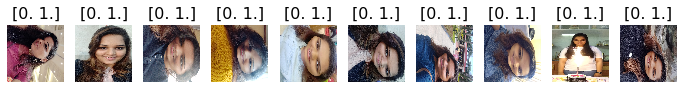

In [10]:
plots(imgs, titles=labels)

In [11]:
#Build and train CNN
model = Sequential([
    Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)), Flatten(), 
    Dense(2, activation='softmax')
])

In [16]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=validate_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 9s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
 - 10s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
 - 6s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


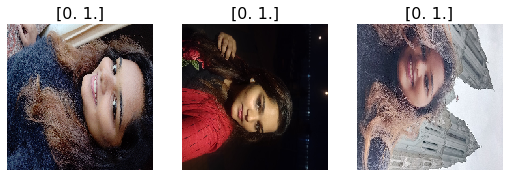

In [32]:
#predict
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)


In [33]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 0.], dtype=float32)

In [34]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [35]:
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [36]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [41]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max()/ 2
    for i, j in itertools.product(range(cm.shap[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, without normalization
[[3]]


AttributeError: 'numpy.ndarray' object has no attribute 'shap'

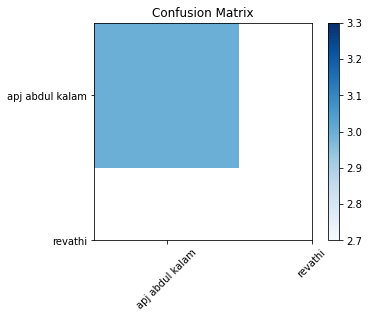

In [42]:
cm_plot_labels = ['apj abdul kalam','revathi']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [45]:
#Build Fine Tuned VGG16 model
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 531s 1us/step


In [46]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [47]:
type(vgg16_model)

keras.engine.training.Model

In [48]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [50]:
model.layers.pop()

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [53]:
for layer in model.layers:
    layer.trainable = False

In [54]:
model.add(Dense(2, activation='softmax'))

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [44]:
#Train the Fine Tuned vgg16 model 
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=validate_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 10s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
 - 9s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
 - 9s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
 - 6s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
 - 9s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


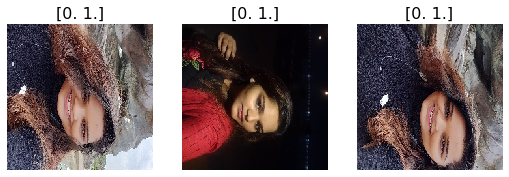

In [65]:
#predict using fine tuned vgg16 model
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [59]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 0.], dtype=float32)

In [66]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [67]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets